read in files,
find pattern,
fourier transform,
overlay splodges (crop and move),
inverse fourier transform back,
check normalisation coditions are fit for purpose,

In [ ]:
# Copyright (C) 2017 Josh Edwards <Josh.Edwards222@gmail.com>
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this.  If not, see <http://www.gnu.org/licenses/>.

In [86]:
!pip install unwrap
!pip install opencv-python

In [65]:
#import required packs
import scipy
import numpy
import PIL
import matplotlib.pyplot as plt
import scipy.fftpack
import math
%matplotlib inline
import numpy.ma as ma
from unwrap import unwrap
import cv2

#please note, numpy array indexing is done [y,x] hence there are some oddities in this code to overcome missmatches
#that this causes


In [66]:
# setting parameters and defining functions for padding and masking
MIDDLE = [900,975]
DIAMETER = 1200

def padfunct(dataarray,sizearray):
    #function to pad cropped arrays to original size
    pad=numpy.zeros((sizearray.shape),dtype=complex)
    pad[int((pad.shape[1]/2)-dataarray.shape[1]/2):int((pad.shape[1]/2+dataarray.shape[1]/2)),int((pad.shape[0]/2)-dataarray.shape[0]/2):int((pad.shape[0]/2+dataarray.shape[0]/2))] = dataarray
    return(pad)


In [67]:
#collect image from file
im = PIL.Image.open('c:/Users/josh/MY Documents/DeepSIM_interference_test.PNG')

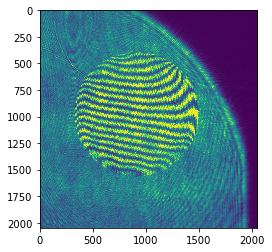

In [68]:
#convert image to array and float
data = numpy.asarray(im)
datafloat=numpy.zeros((data.shape),dtype=float)
datafloat=data*1.0
plt.imshow(data)

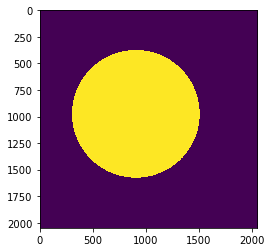

In [69]:
#create the mask to cut out unwanted image areas
mask = numpy.ones(data.shape)
mask=cv2.circle(mask,center=tuple(MIDDLE),radius=int(round(DIAMETER/2)),color=0, thickness=-1)
mask=mask-1
mask=abs(mask)
plt.imshow(mask)

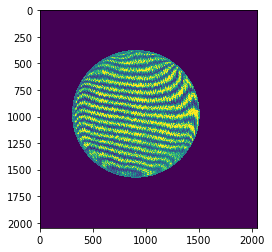

In [70]:
#mask image to remove extraneous data from edges
datafloat = datafloat*mask
plt.imshow(datafloat)

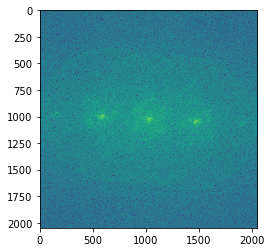

In [71]:
#perform fourier transform and plot
fftarray = numpy.fft.fft2(datafloat, norm='ortho')
fftarray = numpy.fft.fftshift(fftarray)
plt.imshow(numpy.log(abs(fftarray)))

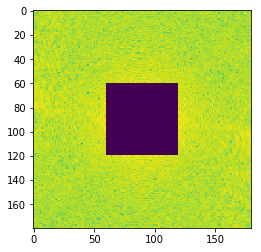

In [72]:
#remove center section to allow finding of 1st order point
REGION=30
centre=[int(fftarray.shape[1]/2),int(fftarray.shape[0]/ 2)]
order0 = numpy.log((fftarray[centre[1]-REGION:centre[1]+REGION,centre[0]-REGION:centre[0]+REGION]))
fftarray[centre[1]-REGION:centre[1]+REGION,centre[0]-REGION:centre[0]+REGION]=0.00001+0j
plt.imshow(numpy.log(abs(fftarray[centre[1]-REGION*3:centre[1]+REGION*3,centre[0]-REGION*3:centre[0]+REGION*3])))

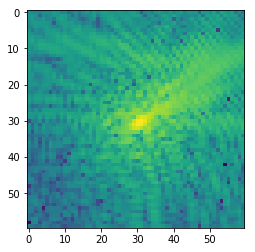

In [73]:
#find first order point
maxpoint = numpy.argmax(fftarray)
maxpoint = [int(maxpoint%fftarray.shape[1]),int(maxpoint/fftarray.shape[1])]
plt.imshow(numpy.log(abs(fftarray[maxpoint[1]-REGION:maxpoint[1]+REGION,maxpoint[0]-REGION:maxpoint[0]+REGION])))
order1 = ((fftarray[maxpoint[1]-REGION:maxpoint[1]+REGION,maxpoint[0]-REGION:maxpoint[0]+REGION]))

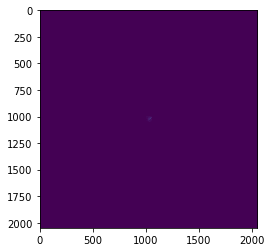

In [74]:
#pad the fftarray back to original size
order1pad=padfunct(order1,data)
plt.imshow(abs(order1pad))

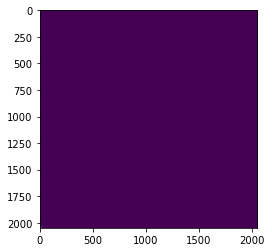

In [75]:
#shift the quadrants back to format for ifft use
order1pad = numpy.fft.ifftshift(order1pad)
plt.imshow(abs(order1pad))

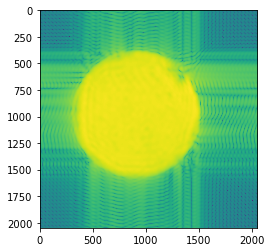

In [76]:
#inverse fourier transform 
ifftorder1 = numpy.fft.ifft2(order1pad, norm='ortho')
plt.imshow(numpy.log(abs(ifftorder1)))

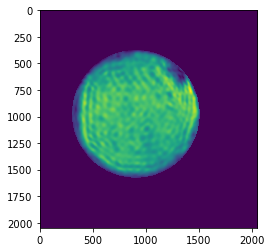

In [77]:
#mask ifftarray to remove extraneous data from edges
ifftorder1=ifftorder1*mask
plt.imshow(abs(ifftorder1))

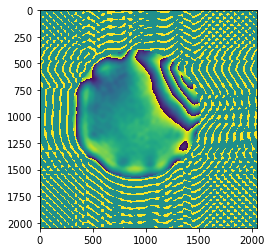

In [78]:
#find phase data by taking 2d arctan of imaginary and real parts
phaseorder1 = numpy.zeros(ifftorder1.shape)
phaseorder1 = numpy.arctan2(ifftorder1.imag,ifftorder1.real)
plt.imshow((phaseorder1))

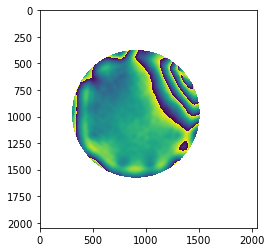

In [79]:
#mask out edge region to allow unwrap to only use correct region
phasesave = phaseorder1
phaseorder1mask = ma.masked_where(mask ==0,phaseorder1)
plt.imshow(phaseorder1mask)

C:\Users\josh\Anaconda3\lib\site-packages\unwrap\unwrap2D.py:30: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  wrap_around_x, wrap_around_y)


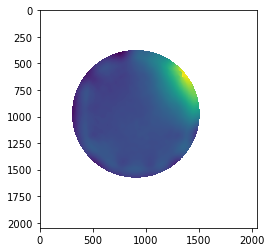

In [80]:
#perform unwrap
phaseunwrap = unwrap(phaseorder1mask)
plt.imshow(phaseunwrap)

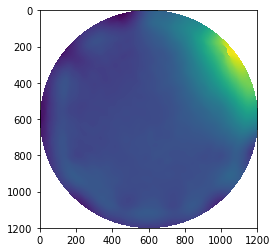

In [82]:
#crop to fill array to improve performance of zernike decomposition
out = numpy.zeros((DIAMETER,DIAMETER), dtype=float)
out = phaseunwrap[MIDDLE[1]-int(round(DIAMETER/2)):MIDDLE[1]+int(round(DIAMETER/2)),MIDDLE[0]-int(round(DIAMETER/2)):MIDDLE[0]+int(round(DIAMETER/2))]
plt.imshow(out)
numpy.savetxt('unwrapped_phase.txt',phaseunwrap)